In [1]:
from utils import * 

In [2]:
save_path = '../CSF/Notebooks/'
import os
os.chdir("../../scVI/")
os.getcwd()

import pickle
import numpy as np
import pandas as pd

In [3]:
import torch

In [4]:
from umap import UMAP

In [5]:
from sklearn.cluster import SpectralClustering

In [6]:
from scvi.inference import UnsupervisedTrainer
from scvi.models import VAE

In [12]:
with open(save_path + 'dataset/all_datasets.pkl', 'rb') as f:
    gene_dataset = pickle.load(f)


In [8]:
%matplotlib inline

In [13]:
samplename = 'allgenes'
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches,
      n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)

if os.path.isfile(save_path+'models/vae.%s.pkl' % samplename ):
    trainer.model.load_state_dict(torch.load(save_path+'models/vae.%s.pkl' % samplename))
    trainer.model.eval()
else:
    trainer.train(n_epochs=100)
    torch.save(trainer.model.state_dict(), save_path+'models/vae.%s.pkl'  % samplename)
    
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))


In [14]:
with open(save_path + 'posterior/all_datasets.vae.full.pkl', 'wb') as f:
    pickle.dump(full,f)

In [15]:
with open(save_path + 'posterior/all_datasets.vae.full.pkl', 'rb') as f:
    full = pickle.load(f)

In [7]:
# latent, batch_indices, labels = full.sequential().get_latent()
# latent_u = UMAP(spread=2).fit_transform(latent)
# np.save(save_path + 'UMAP/all_dataset.umap.npy',latent_u)
latent_u = np.load(save_path + 'UMAP/all_dataset.umap.npy')

In [18]:
# clusters = louvain_clusters(latent, k=30)
# np.save(save_path + 'clusterings/louvain.k30.allgenes.npy',clusters)
clusters = np.load(save_path + 'meta/louvain.k30.allgenes.npy')

In [26]:
celltypes = np.asarray(['CD8a','CD4','CD4','CD4','Gran',
             'B cells','NK1','Tregs','CD8n','RBC',
             'Mono','Tdg','Mono Doublet','mDC','NK2',
             'contamination1','pDC','B cell doublets','plasma','MegaK',
             'doublet']
)

In [15]:
len(celltypes)

21

In [21]:
doublet = np.load('../CSF/Notebooks/meta/predicted_doublets.npy')

In [35]:
np.asarray(celltypes)[np.asarray([np.mean(doublet[clusters==x]) for x in np.unique(clusters)])>0.2]

array(['Mono Doublet', 'B cell doublets', 'doublet'], dtype='<U15')

# Further split ncMono, B cell cluster and mDC cluster

In [ ]:
Bcells = np.unique(clusters)[celltypes=='B cells'][0]

clustering = SpectralClustering(n_clusters=2, n_jobs=-1, affinity ="nearest_neighbors",n_neighbors=15)
%time Bclusters = clustering.fit_predict(latent[clusters==Bcells,:])

plt.scatter(latent_u[clusters==Bcells,0],latent_u[clusters==Bcells,1],c=Bclusters,s=5)

In [ ]:
Mono = np.unique(clusters)[celltypes=='Mono'][0]
%time Monoclusters = clustering.fit_predict(latent[clusters==Mono,:])
plt.scatter(latent_u[clusters==Mono,0],latent_u[clusters==Mono,1],c=Monoclusters,s=5)

In [ ]:
mDC = np.unique(clusters)[celltypes=='mDC'][0]
%time mDCclusters = clustering.fit_predict(latent[clusters==mDC,:])
plt.scatter(latent_u[clusters==mDC,0],latent_u[clusters==mDC,1],c=mDCclusters,s=5)

In [ ]:
celllabels = np.repeat(None,len(clusters))

for i,x in enumerate(celltypes):
    celllabels[clusters==i] = np.repeat(x,np.sum(clusters==i))

Blabels = np.repeat(None,len(Bclusters))
for i,x in enumerate(['B1','B2']):
    Blabels[Bclusters==i] = np.repeat(x,np.sum(Bclusters==i))

mDClabels = np.repeat(None,len(mDCclusters))
for i,x in enumerate(['mDC2','mDC1']):
    mDClabels[mDCclusters==i] = np.repeat(x,np.sum(mDCclusters==i))
    

Monolabels = np.repeat(None,len(Monoclusters))
for i,x in enumerate(['ncMono','Mono']):
    Monolabels[Monoclusters==i] = np.repeat(x,np.sum(Monoclusters==i))

celllabels[celllabels=='B cells'] = Blabels
celllabels[celllabels=='mDC'] = mDClabels
celllabels[celllabels=='Mono'] = Monolabels

In [ ]:
# np.save(save_path + 'meta/celllabels.npy',celllabels)

In [8]:
save_path = './'


In [9]:
celllabels = np.load(save_path + 'meta/celllabels.npy')
celltype, labels = np.unique(celllabels, return_inverse=True)

In [16]:
len(celltype)

22

# proportion plots

In [16]:
tissue=np.concatenate([np.repeat('CSF',8),np.repeat('PBMC',10)])
states=np.asarray(['MS','MS','MS','MS','control','control','control','control',
                   'MS','MS','MS','MS','MS','control','control','control','control','control'])


batchid = batch_indices.ravel().astype('int')
isMS = np.asarray([states[i]=='MS' for i in batchid])
isCSF = np.asarray([tissue[i]=='CSF' for i in batchid])


In [ ]:
# np.save(save_path+'dataset/isMS.npy',isMS)
# np.save(save_path+'dataset/isCSF.npy',isCSF)
# np.save(save_path+'dataset/batchid.npy', batchid)

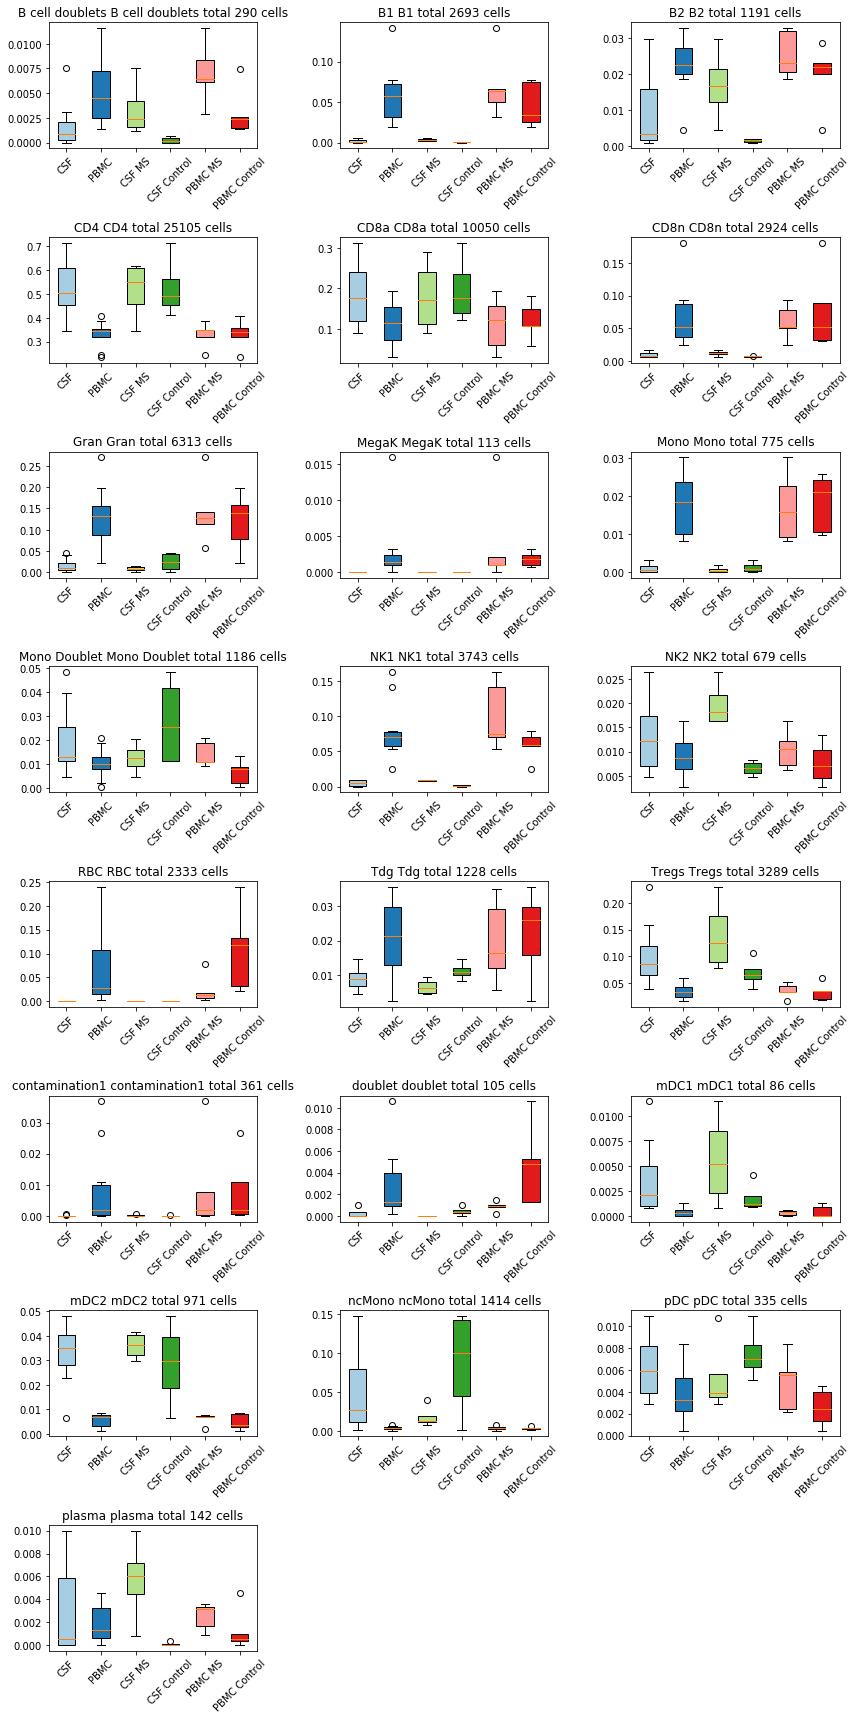

In [18]:
# clusters,batchid,cluster_description,tissue,states,celltypes
ClusterProp(labels,batchid,celltype,tissue,states,celltype)